# Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import pearsonr, zscore
import statsmodels.api as sm
import calendar
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
sns.set(style="whitegrid")

# Loading the Data

In [2]:
df = pd.read_parquet("data/preprocessed/monthly_agg.parquet")

# Statistics Descriptive

,count,mean,std,min,25%,50%,75%,max,skew
total_qty,"434,506.00",26.37,240.24,0.00,0.00,0.00,3.00,"80,995.00",166.75
total_sales,"434,506.00",46.32,415.90,0.00,0.00,0.00,9.96,"168,469.60",181.30
avg_unit_price,"434,506.00",3.36,5.89,0.00,1.25,1.95,3.75,295.00,18.73
txn_count,"434,506.00",2.39,9.94,0.00,0.00,0.00,1.00,439.00,9.57
cust_nunique,"434,506.00",1.76,7.17,0.00,0.00,0.00,1.00,298.00,9.40


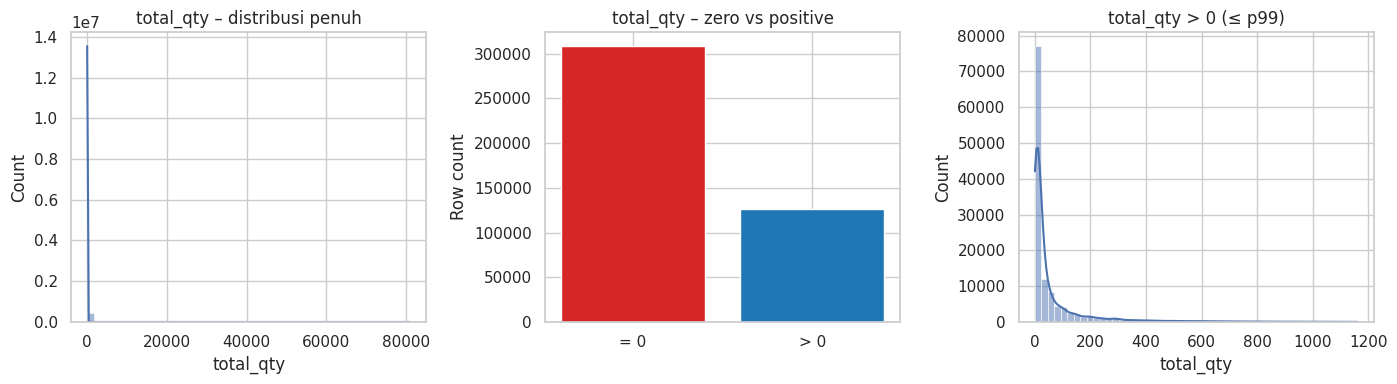

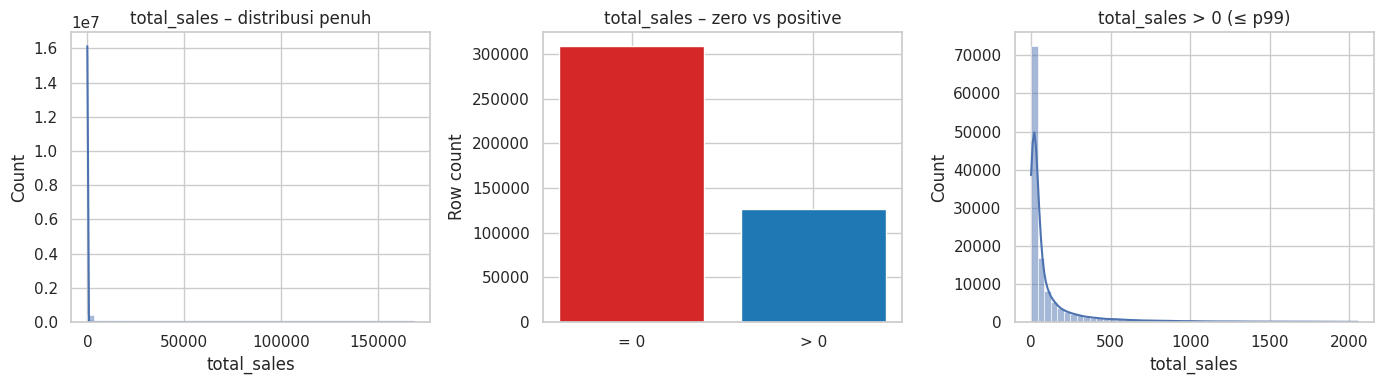

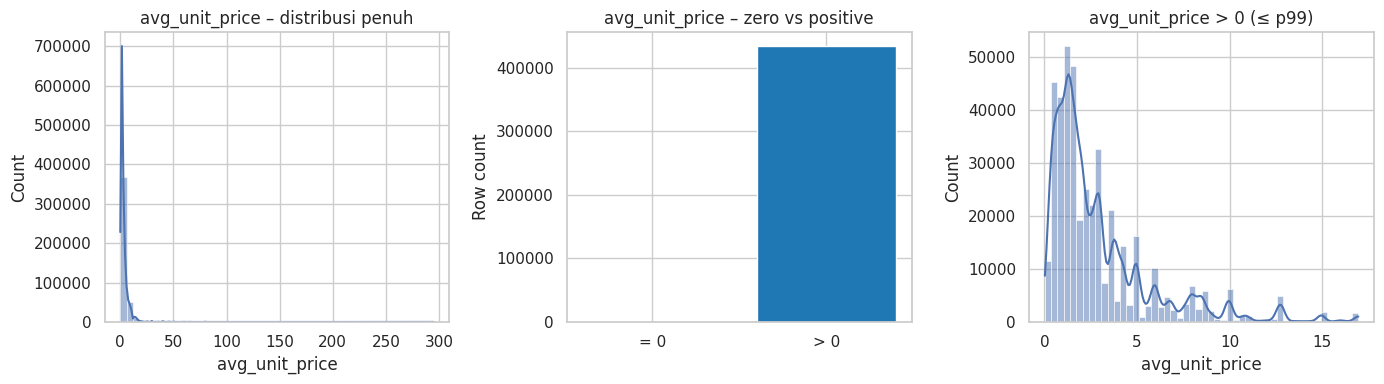

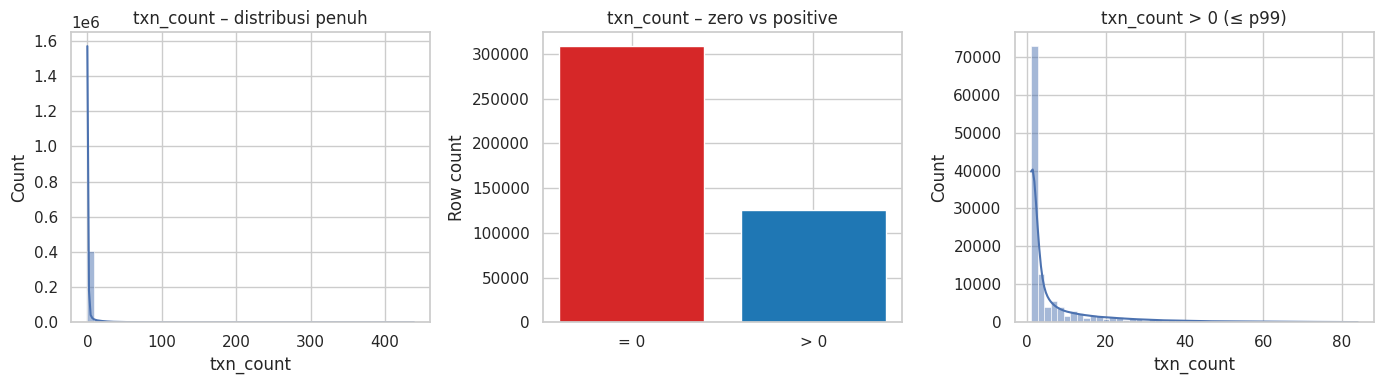

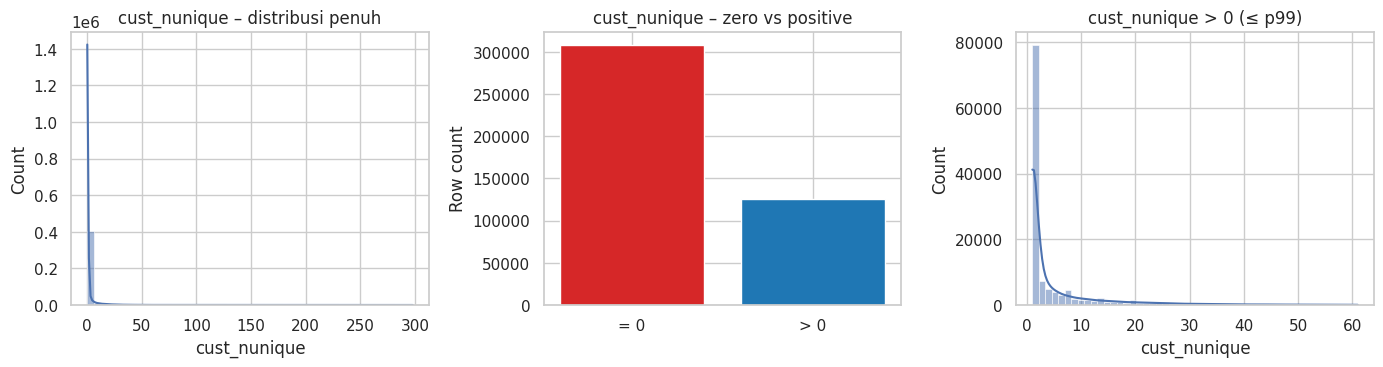

In [3]:
NUM_COLS   = ['total_qty', 'total_sales',
              'avg_unit_price', 'txn_count', 'cust_nunique']
CLIP_PCT   = 99      
BINS       = 50      
FIG_W, FIG_H = 14, 4 

# Basic stat
stats = df[NUM_COLS].describe().T
stats["skew"] = df[NUM_COLS].skew()
display(
    stats.style
         .format("{:,.2f}")
         .background_gradient(subset=["max", "75%"], cmap="Blues")
         .bar(subset=["mean", "50%"], color="#ffd65c")
)

# Plot Function
def plot_option(series, name, bins=BINS, clip_pct=CLIP_PCT):
    s = series.dropna()

    fig, axes = plt.subplots(1, 3, figsize=(FIG_W, FIG_H))

    # ── Panel A: distribusi  ─────────────────────────────────
    sns.histplot(s, bins=bins, kde=True, ax=axes[0])
    axes[0].set_title(f"{name} – distribusi penuh")
    axes[0].set_xlabel(name); axes[0].set_ylabel("Count")

    # ── Panel B: zero vs positive ────────────────────────────────
    zero_cnt = (s == 0).sum()
    pos_cnt  = (s > 0).sum()
    axes[1].bar(["= 0", "> 0"], [zero_cnt, pos_cnt],
                color=["tab:red", "tab:blue"])
    axes[1].set_title(f"{name} – zero vs positive")
    axes[1].set_ylabel("Row count")

    # ── Panel C: distribusi positif (≤ p{clip_pct}) ──────────────
    pos_vals = s[s > 0]
    if pos_vals.empty:
        axes[2].text(0.5, 0.5, "⟨ tidak ada nilai > 0 ⟩",
                     ha="center", va="center")
        axes[2].axis("off")
    else:
        upper = np.percentile(pos_vals, clip_pct)
        zoom  = pos_vals[pos_vals <= upper]
        sns.histplot(zoom, bins=bins, kde=True, ax=axes[2])
        axes[2].set_title(f"{name} > 0 (≤ p{clip_pct})")
        axes[2].set_xlabel(name); axes[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

# Plot
for col in NUM_COLS:
    if col not in df.columns:
        print(f"Kolom “{col}” tidak ditemukan.")
        continue
    plot_option(df[col], col)

- Hampir semua kolom median nya 0 (kecuali harga karena input nya menggunakan forward fill). Hal ini menunjukkan transaksi yang sangat sparse untuk setiap series
- Extreme right skew (mean > median > mode). pada plot juga dapat dilihat bahwa distribusi semua kolom adalah right skew. Standar deviasi nya juga hampir 10x mean yang menunjukkan long tail distribution

# Pareto Analysis


=== Top 10 Produk by Sales ===


,stockcode,total_sales,%_dari_total
0,22423,344563.25,1.712028
1,85123A,263109.67,1.307311
2,85099B,183454.83,0.91153
3,23843,168469.6,0.837073
4,47566,149187.05,0.741264
5,84879,132187.92,0.656801
6,22086,123141.54,0.611852
7,79321,85489.91,0.424773
8,23166,81700.92,0.405947
9,22197,80920.64,0.40207


/tmp/ipykernel_496359/720447487.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_prod["stockcode"], y=top_prod["total_sales"],


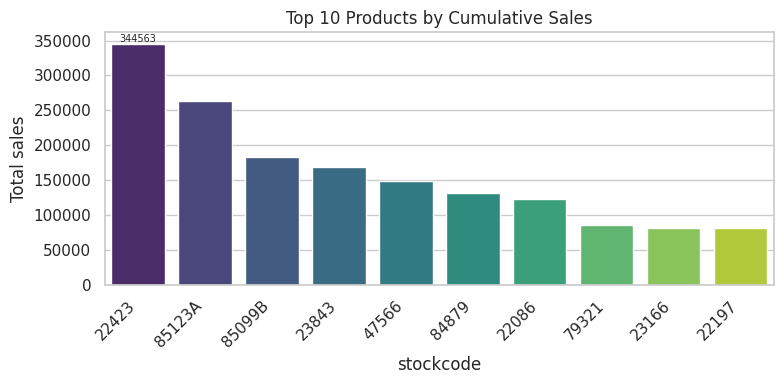

In [4]:
# Pareto product
TOP_N        = 10
RANDOM_SEED  = 42      # (dipakai di pair-plot, boleh diabaikan di sini)

# hitung sales per SKU
totals      = (df.groupby("stockcode")["total_sales"]
                 .sum()
                 .sort_values(ascending=False))

total_all   = totals.sum()                 # total revenue seluruh SKU
top_prod    = totals.head(TOP_N).reset_index()
leader_val  = top_prod["total_sales"].iloc[0]

# Tambah kolom persentase 
top_prod["%_dari_total"]  = 100 * top_prod["total_sales"] / total_all

# print table
print("\n=== Top 10 Produk by Sales ===")
display(top_prod)

# visualisasi
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=top_prod["stockcode"], y=top_prod["total_sales"],
            ax=ax, palette="viridis")
ax.set_title(f"Top {TOP_N} Products by Cumulative Sales")
ax.set_ylabel("Total sales"); ax.set_xlabel("stockcode")
ax.bar_label(ax.containers[0], fmt="%.0f", fontsize=7)
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()


- 10 SKU terlaris hanya menyumbang 7% dari total revenue (Artinya bisnis terfragmentasi/tidak ada yang dominan)
- Leader != Dominator. SKU 22423 hanya menyumbang 1.71% dari total revenue


=== Top 10 Country by Sales ===


,country,total_sales,share_total,vs_leader
0,United Kingdom,17238992.53,85.655235,100.0
1,EIRE,638933.63,3.174664,3.706328
2,Netherlands,549952.66,2.732545,3.190167
3,Germany,388829.75,1.931975,2.255525
4,France,317344.8,1.576788,1.840855
5,Australia,168484.66,0.837148,0.977346
6,Spain,98612.79,0.489977,0.572033
7,Switzerland,94270.29,0.4684,0.546843
8,Sweden,86353.04,0.429062,0.500917
9,Denmark,68560.19,0.340654,0.397704


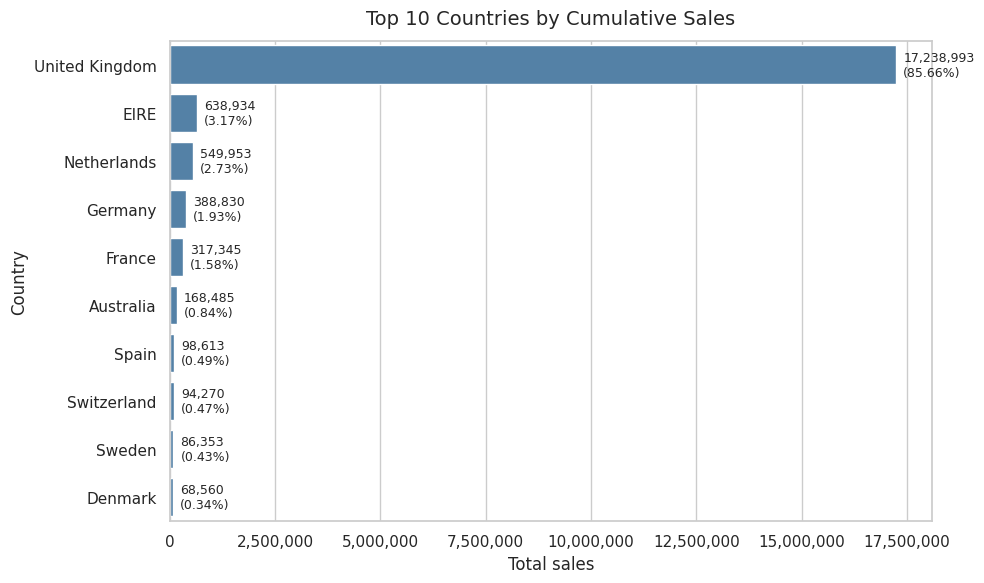

In [5]:
# Hitung total sales per negara 
ctry_totals = (df.groupby("country")["total_sales"]
                 .sum()
                 .sort_values(ascending=False))

grand_total = ctry_totals.sum()            # total sales semua negara
top_ctry_df = (ctry_totals.head(TOP_N)
               .reset_index(name="total_sales"))

leader_val  = top_ctry_df["total_sales"].iloc[0]

# Tambah kolom persentase
top_ctry_df["share_total"] = 100 * top_ctry_df["total_sales"] / grand_total
top_ctry_df["vs_leader"]   = 100 * top_ctry_df["total_sales"] / leader_val

# Print table
print("\n=== Top 10 Country by Sales ===")
display(top_ctry_df)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=top_ctry_df, y="country", x="total_sales",
            ax=ax, color="steelblue")

ax.set_title(f"Top {TOP_N} Countries by Cumulative Sales", fontsize=14, pad=12)
ax.set_xlabel("Total sales")
ax.set_ylabel("Country")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _:
                                           f"{x:,.0f}"))
for idx, bar in enumerate(ax.patches):
    width  = bar.get_width()
    y_pos  = bar.get_y() + bar.get_height() / 2
    pct    = top_ctry_df.loc[idx, "share_total"]
    ax.text(width + 0.01 * leader_val,          # offset 1 % dari bar terpanjang
            y_pos,
            f"{width:,.0f}\n({pct:.2f}%)",
            ha="left", va="center", fontsize=9)

plt.tight_layout()
plt.show()


- UK berkontribusi ke 85% global sales
- Selain UK, sales nya terfragmentasi (tidak begitu dominan)

Takeaway :
- Target utk improve forecasting model & stock optimization model di region UK. Karena transaksi UK kontribusi ke 85% sales
- Ireland & Netherlands negara pilihan untuk melakukan ekspansi karena sales nya sudah cukup tinggi (jika dibandingkan dengan selain UK)

# Corellation Analysis

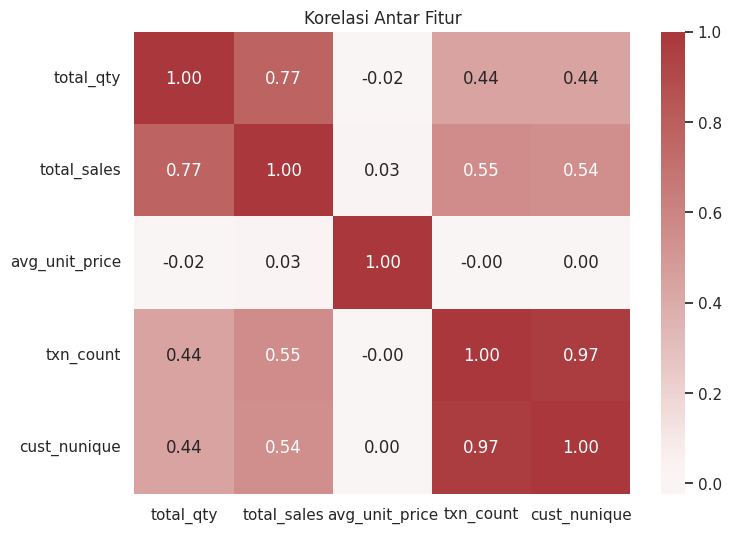

In [6]:
# Hitung korelasi numeric feature
corr_feats = df[NUM_COLS].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_feats, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Korelasi Antar Fitur")
plt.show()

- (total_qty x total_sales x avg_unit_price) Sales di-drive oleh quantity (bukan karena variasi price)
- (total_sales x txn_count) seharusnya makin tinggi transaksi maka makin tinggi sales nya. akan tetapi korelasi nya positif lemah. artinya pada setiap transaksi qty nya beragam
- (cust_nunique x txn_count) memiliki korelasi yang tinggi. seiring meningkat nya transaksi maka jumlah customer meningkat, yang artinya di setiap transaksi kebanyakan melibatkan 1 customer

Takeaway
- Aggregate demand terlihat tidak sensitif terhadap harga (initial assumption, need crosscheck)

# Time Series Plot

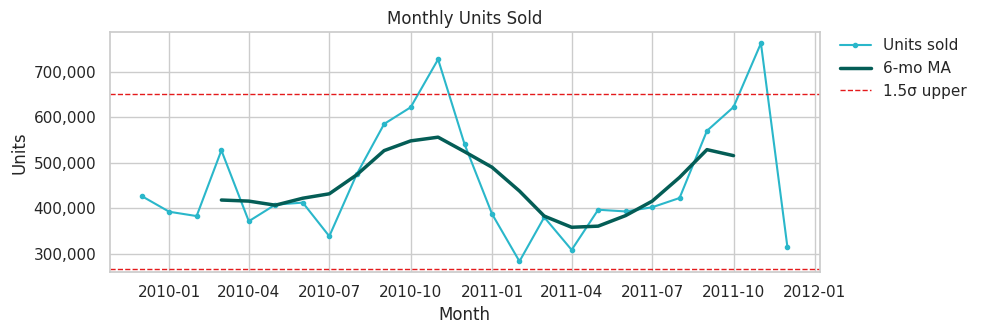

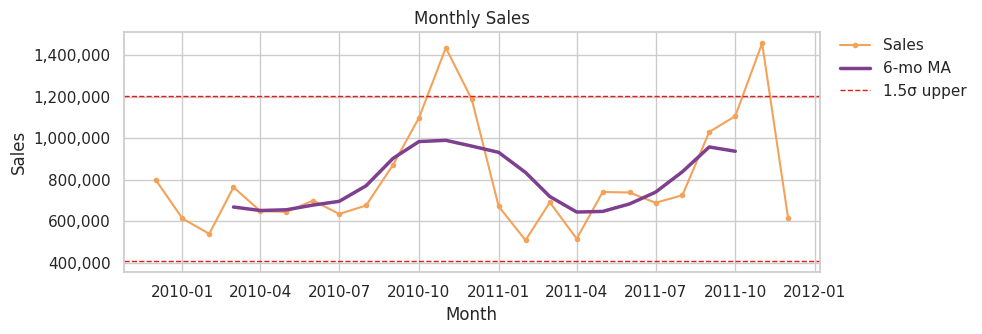

In [7]:
# Aggregasi bulanan
df["date"] = pd.to_datetime(df["date"], errors="coerce")
m = (df.assign(month=df["date"].dt.to_period("M").dt.to_timestamp())
       .groupby("month")[["total_qty", "total_sales"]].sum().sort_index())

# Hitung MA
m["qty_ma"]   = m["total_qty"].rolling(6, center=True).mean()
m["sales_ma"] = m["total_sales"].rolling(6, center=True).mean()

# Outlier treshold (utk visualisasi)
qty_mu,   qty_sigma   = m["total_qty"].mean(),   m["total_qty"].std()
sales_mu, sales_sigma = m["total_sales"].mean(), m["total_sales"].std()
qty_hi, qty_lo       = qty_mu + 1.5*qty_sigma, max(0, qty_mu - 1.5*qty_sigma)
sales_hi, sales_lo   = sales_mu + 1.5*sales_sigma, max(0, sales_mu - 1.5*sales_sigma)

# color_dict
col = dict(
    qty_raw ="#2AB7CA", qty_ma ="#045D56",
    sales_raw="#F4A259", sales_ma="#7E3F8F",
    thresh="#E41A1C")

# Plot unit sold
plt.figure(figsize=(10, 3.5))
plt.plot(m.index, m["total_qty"],  color=col["qty_raw"],  lw=1.5,
         marker="o", ms=3, label="Units sold")
plt.plot(m.index, m["qty_ma"], color=col["qty_ma"], lw=2.5,
         label=f"{6}-mo MA")
plt.axhline(qty_hi, color=col["thresh"], ls="--", lw=1,
            label="1.5σ upper")
if qty_lo > 0:
    plt.axhline(qty_lo, color=col["thresh"], ls="--", lw=1)

plt.title("Monthly Units Sold")
plt.xlabel("Month"); plt.ylabel("Units")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _ : f"{x:,.0f}"))
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0),
           borderaxespad=0, frameon=False)
plt.tight_layout(); plt.show()

# Plot sales
plt.figure(figsize=(10, 3.5))
plt.plot(m.index, m["total_sales"],  color=col["sales_raw"],  lw=1.5,
         marker="o", ms=3, label="Sales")
plt.plot(m.index, m["sales_ma"], color=col["sales_ma"], lw=2.5,
         label=f"{6}-mo MA")
plt.axhline(sales_hi, color=col["thresh"], ls="--", lw=1,
            label="1.5σ upper")
if sales_lo > 0:
    plt.axhline(sales_lo, color=col["thresh"], ls="--", lw=1)

plt.title("Monthly Sales")
plt.xlabel("Month"); plt.ylabel("Sales")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _ : f"{x:,.0f}"))
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0),
           borderaxespad=0, frameon=False); 
plt.tight_layout(); plt.show()


- Pada oktober-november 2010 & oktober-november 2011 terdapat outlier (melebihi treshold garis merah & diatas rata-rata 6 bulan (MA)). Jika dilihat oktober-november terletak pada Q4. Fitur flag bulan atau quarter mungkin dibutuhkan untuk modeling
- Penjualan menurun pada awal tahun (januari - maret)
- Grafik sales & unit sold mirip (seperti pada korelasi analisis tadi, penjualan di drive oleh quantity (bukan krn price)). Mungkin menarik untuk deepdive point ini (lanjut price elasticity)

Takeaway :
- Pertimbangkan model yang dapat capture seasonality
- Buffer stock khusus utk Q4
- Pada Q1 perlu hati2 agar tidak overstock & rekomendasi untuk melakukan campaign promo

# Price Elasticity

Aggregate elasticity (no outliers): -0.625 (SE=0.005, p=0)


/tmp/ipykernel_496359/489668113.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_elastic)



Elasticities for 3,184 series (≥ 12 obs, no outliers).

Summary of clipped elasticities:
mean     1.713
std      6.101
5%      -4.710
50%      0.470
95%     12.067


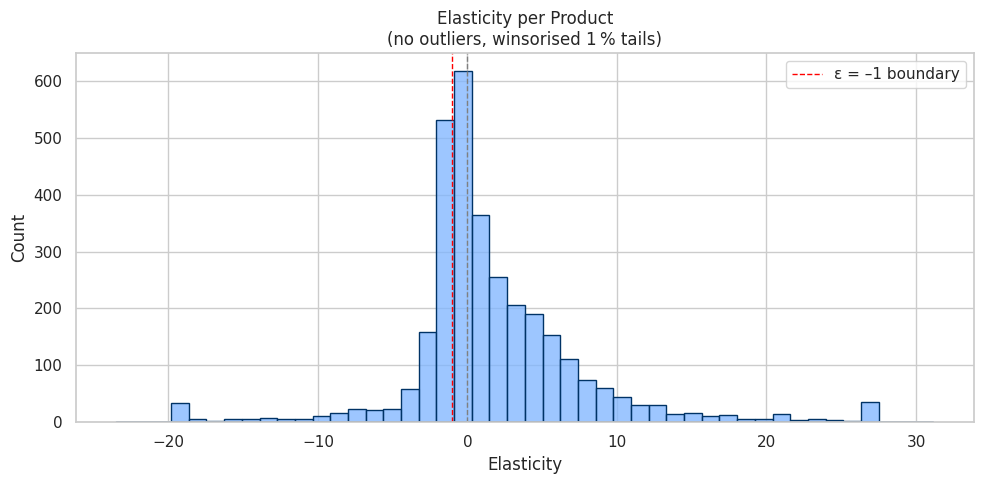

In [8]:
# Prepare data – only positives & non‑outliers
elastic_df = df[
    (df["avg_unit_price"] > 0) &
    (df["total_qty"]   > 0) &
    (~df["total_qty_is_outlier"])
][["avg_unit_price", "total_qty", "stockcode"]].copy()

# Log transforms
elastic_df["log_price"] = np.log(elastic_df["avg_unit_price"])
elastic_df["log_qty"]   = np.log(elastic_df["total_qty"])

# Aggregate elasticity (entire filtered dataset)
X = sm.add_constant(elastic_df["log_price"])
agg_model = sm.OLS(elastic_df["log_qty"], X).fit()
agg_e = agg_model.params["log_price"]
print(
    f"Aggregate elasticity (no outliers): {agg_e:.3f} "
    f"(SE={agg_model.bse['log_price']:.3f}, p={agg_model.pvalues['log_price']:.3g})"
)

# Per‑product elasticity
def _elastic(group):
    if len(group) < 12:            # MIN_N = 12
        return np.nan
    # if statsmodels available
    try:
        Xp = sm.add_constant(group["log_price"])
        return sm.OLS(group["log_qty"], Xp).fit().params["log_price"]
    except Exception:
        # fallback to numpy polyfit
        slope, _ = np.polyfit(group["log_price"], group["log_qty"], 1)
        return slope

elasticities = (
    elastic_df
      .groupby("stockcode", group_keys=False)
      .apply(_elastic)
      .dropna()
      .rename("elasticity")
      .to_frame()
)

print(f"\nElasticities for {len(elasticities):,} series (≥ 12 obs, no outliers).")

# Winsorise 1% tails for plotting (TAIL_CUT = 0.01)
lo, hi = elasticities["elasticity"].quantile([0.01, 0.99])
elasticities["elasticity_clip"] = elasticities["elasticity"].clip(lo, hi)

# Summary stats
summary = elasticities["elasticity_clip"].describe(percentiles=[.05, .5, .95])
print("\nSummary of clipped elasticities:")
print(summary[["mean", "std", "5%", "50%", "95%"]].round(3).to_string())

# Distribution plot
plt.figure(figsize=(10, 5))
ax = sns.histplot(
    elasticities["elasticity_clip"],
    bins=40,
    color="#7db4ff",
    edgecolor="#003366",
    kde=False
)
sns.kdeplot(
    data=elasticities["elasticity_clip"],
    ax=ax,
    color="#003366",
    linewidth=1.4
)
plt.axvline(0,  color="grey", ls="--", lw=1)
plt.axvline(-1, color="red",  ls="--", lw=1, label="ε = –1 boundary")
plt.title("Elasticity per Product\n(no outliers, winsorised 1 % tails)")
plt.xlabel("Elasticity")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

- Aggregat elasticity di -0.625. Yang artinya demands bersifat inelastic (kenaikan price 1% berdampak pada penurunan -0.625% drop di quantity)
- Median elasticity di 0.47. Yang artinya 1/2 series memiliki elasticity positif (quantity ↑ as price ↑). Kemungkinan karena dipengaruhi beberapa produk dengan volume kecil dan memiliki elasticity positif (karena promo, bundling etc)

- Business Take‑aways (Menerapkan SKU level strategy) :
    - **Inelastic core (–1 < ε < 0)**: Kandidat untuk melakukan dynamic pricing
    - **Elastic tail (ε < –1)**: Harga dibuat lebih competitive


# Calendar heat-maps & seasonality

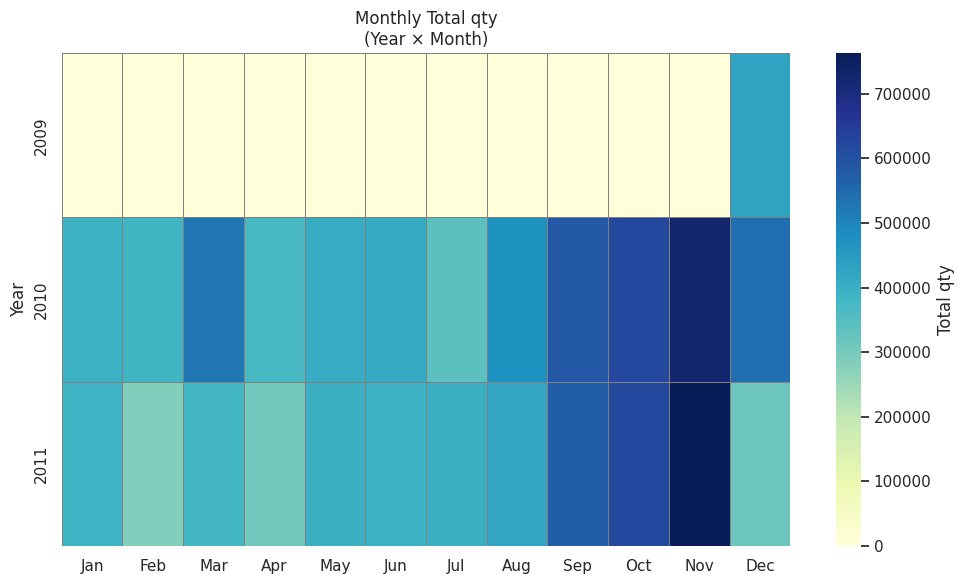

/tmp/ipykernel_496359/1956240151.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=agg_month,


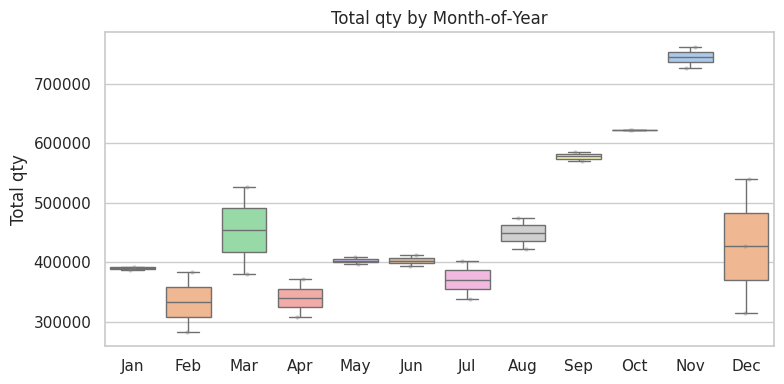

In [9]:
# Aggregation
df['total_qty'] = pd.to_numeric(df['total_qty'], errors='coerce')

agg_month = (
    df.groupby("date")['total_qty']
      .sum()
      .reset_index()
)

agg_month["year"]  = agg_month["date"].dt.year
agg_month["month"] = agg_month["date"].dt.month

# pivot
pivot = (
    agg_month
      .pivot(index="year", columns="month", values="total_qty")
      .fillna(0)
      .astype(float)     # ← force float dtype here
)

pivot.columns = [calendar.month_abbr[m] for m in pivot.columns]

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot,
            cmap="YlGnBu",
            linewidths=0.5,
            linecolor="gray",
            cbar_kws=dict(label="Total qty"))
plt.title("Monthly Total qty\n(Year × Month)")
plt.ylabel("Year")
plt.xlabel("")
plt.tight_layout()
plt.show()

# Visualisasi boxplot
plt.figure(figsize=(8, 4))
order = list(calendar.month_abbr)[1:]
sns.boxplot(data=agg_month,
            x=agg_month["month"].map(lambda m: calendar.month_abbr[m]),
            y="total_qty",
            order=order,
            palette="pastel",
            showfliers=False)
sns.stripplot(data=agg_month,
              x=agg_month["month"].map(lambda m: calendar.month_abbr[m]),
              y="total_qty",
              order=order,
              color="gray",
              alpha=0.4,
              size=3)
plt.title("Total qty by Month‑of‑Year")
plt.xlabel("")
plt.ylabel("Total qty")
plt.tight_layout()
plt.show()


- Spike Q4: Setiap tahun (2010–2011), volume paling tinggi terjadi pada **September–November** (warna biru tua).  
- Q1: **Januari–Februari** selalu menunjukkan jumlah paling rendah (warna pucat).  
- Stabil di pertengahan tahun: **Mei–Juli** berada di kisaran menengah, menandakan permintaan stabil.  
- **Catatan 2009**: Hanya Desember 2009 yang tercatat, jadi data 2009 belum menggambarkan pola penuh

# Group-level summaries (Mean, median, cv, etc by group)

In [10]:
# Fungsi untuk generate stat desc per group
numeric_cols = ['total_qty', 'total_sales', 'avg_unit_price',
       'txn_count', 'cust_nunique']
def summarize_group(df, keys, metrics):
    """Return group-level summary with mean, median, std, CV, min, max, count."""
    agg_dict = {}
    for col in metrics:
        agg_dict[col] = ["count", "mean", "median", "std", "min", "max"]
    out = (
        df.groupby(keys)
          .agg(agg_dict)
          .rename(columns={"std": "std_dev"})   # optional rename
    )
    # Flatten MultiIndex kolom → 'units_sold_mean', dst.
    out.columns = ["_".join(col).strip() for col in out.columns]
    
    # Tambahkan Coefficient of Variation (CV = std / mean)
    for col in metrics:
        out[f"{col}_cv"] = out[f"{col}_std_dev"] / out[f"{col}_mean"]
    
    return out.reset_index()
    
summary_df = summarize_group(df, ["series_id"], numeric_cols)

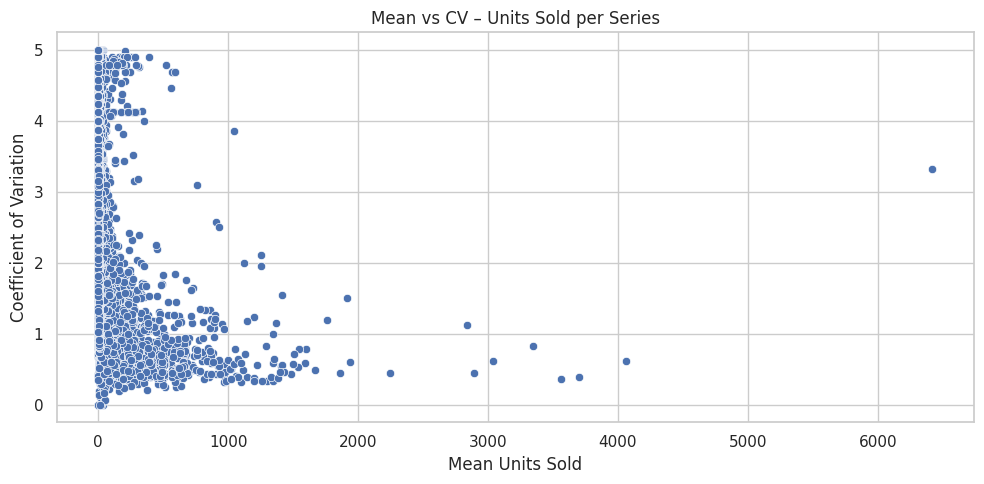

In [11]:
# Scatter mean vs CV untuk units_sold
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=summary_df,
    x='total_qty_mean',
    y='total_qty_cv'
)
plt.title('Mean vs CV – Units Sold per Series')
plt.xlabel('Mean Units Sold')
plt.ylabel('Coefficient of Variation')
plt.tight_layout()
plt.show()

- Tedapat Inverse relationship
- *Series* dengan **mean tinggi** (> 500 unit/bln) memiliki **CV rendah** (< 1), artinya permintaan lebih stabil (mungkin karena jarang yang permintaan nya tinggi sehingga tidak ada variansi)
- Sebaliknya, *series* dengan **mean rendah** (< 100 unit/bln) sering kali menunjukkan **CV tinggi** (> 2), menandakan permintaan tidak teratur.

In [12]:
# sampling 1 series utk plotting
summary_df[summary_df["total_qty_mean"] > 1000].sort_values(by = "total_qty_cv", ascending = False).head(5)

,series_id,total_qty_count,total_qty_mean,total_qty_median,total_qty_std_dev,total_qty_min,total_qty_max,total_sales_count,total_sales_mean,total_sales_median,...,cust_nunique_mean,cust_nunique_median,cust_nunique_std_dev,cust_nunique_min,cust_nunique_max,total_qty_cv,total_sales_cv,avg_unit_price_cv,txn_count_cv,cust_nunique_cv
22080,37410_Denmark,24,1048.5,0.0,4046.247827,0,19152,24,104.85,0.0,...,0.083333,0.0,0.282330,0.0,1.0,3.859082,3.859082,0.000000,3.387958,3.387958
18665,23166_United Kingdom,12,6419.666667,263.5,21351.088711,0,74215,12,6714.635833,325.345,...,13.666667,15.5,11.515470,0.0,28.0,3.325887,3.305222,0.199147,0.81196,0.842595
24314,84347_United Kingdom,25,1254.4,56.0,2647.953486,0,12367,25,2869.9268,185.58,...,17.840000,4.0,23.593219,0.0,79.0,2.110932,1.967383,0.275140,1.308516,1.322490
7779,21980_United Kingdom,25,1123.68,479.0,2241.80613,66,10751,25,308.2324,141.97,...,20.000000,19.0,8.727352,5.0,47.0,1.995057,1.833816,0.169206,0.430984,0.436368
7808,21982_United Kingdom,25,1253.48,463.0,2452.711495,0,11758,25,406.098,156.45,...,19.080000,20.0,11.470687,0.0,48.0,1.956722,1.908771,0.223480,0.6574,0.601189


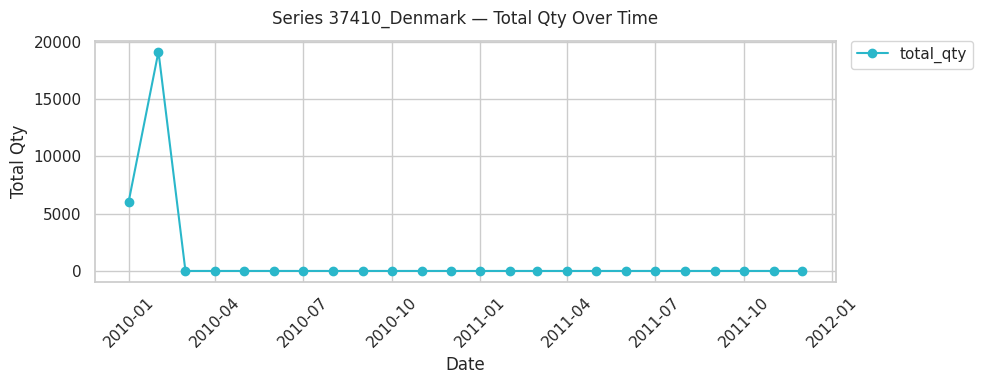

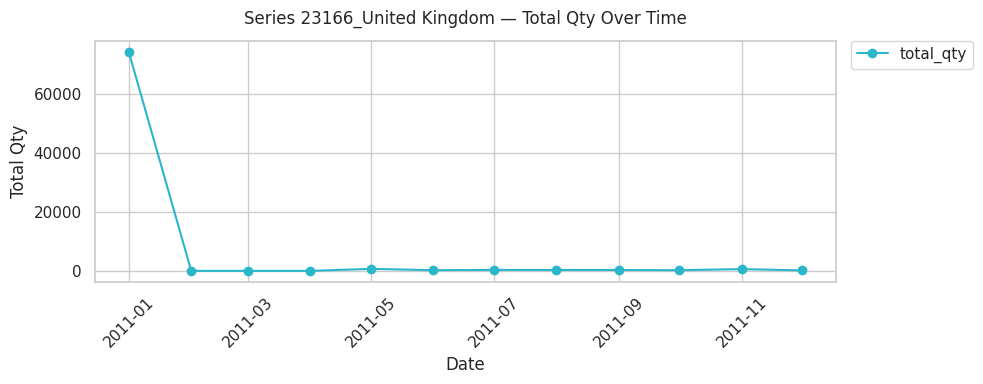

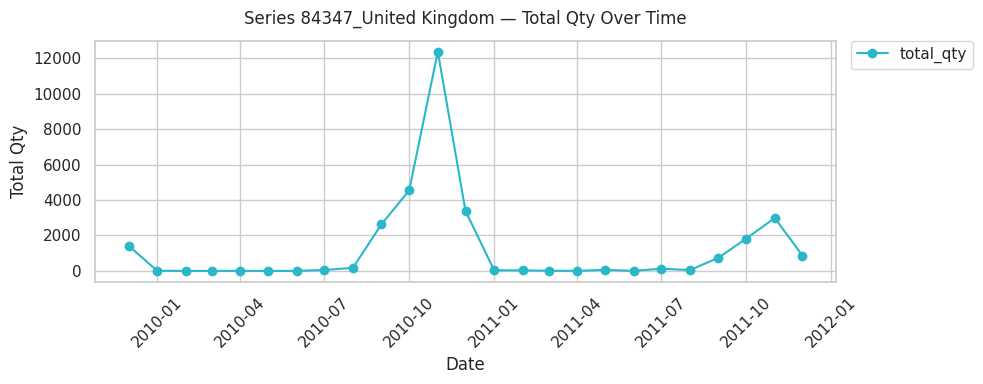

In [13]:
def plot_series(series_id) :
    df_plot = df[df["series_id"] == series_id].copy()
    df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce")
    df_plot = df_plot.sort_values("date")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(df_plot["date"], df_plot["total_qty"],
             marker="o", linestyle="-", color="#2AB7CA", label="total_qty")
    
    # Styling
    plt.title(f"Series {series_id} — Total Qty Over Time", pad=12)
    plt.xlabel("Date")
    plt.ylabel("Total Qty")
    plt.xticks(rotation=45)
    plt.legend(loc="upper left", 
              bbox_to_anchor=(1.02, 1), 
              borderaxespad=0,)
    plt.tight_layout()
    plt.show()

# Plot sample series
list_series_id = ["37410_Denmark", "23166_United Kingdom", "84347_United Kingdom"]
for series_id in list_series_id:
    plot_series(series_id)
   

- Utk series yang cv nya rendah karena hanya ada 1-2 spike kemudian flat

# STL decomposition

STL singkatan dari Seasonal-Trend decomposition using Loess. Tujuannya memecah series menjadi Trend, Seasonal & Noise

In [14]:
# STL semua series
strength = []
for sid, grp in tqdm(df.groupby('series_id')):
    # 1) Pastikan date jadi datetime & index bulanan (Month‑Start)
    ts = (grp
          .assign(date=pd.to_datetime(grp['date'], errors='coerce'))
          .set_index('date')
          .sort_index()
          .resample('MS')['total_qty']   # frekuensi bulanan
          .sum()                         # atau .first() kalau tiap bulan 1 titik
         )
    
    # 2) STL dengan period=12 (siklus tahunan)
    res = STL(ts, period=12, robust=True).fit()
    
    # 3) Hitung kekuatan komponen
    trend_str = 1 - (res.resid.var() / (res.trend + res.resid).var())
    seas_str  = 1 - (res.resid.var() / (res.seasonal + res.resid).var())
    
    strength.append({
        "series_id": sid,
        "trend_strength":    trend_str,
        "seasonal_strength": seas_str
    })

stl_stats = pd.DataFrame(strength)

 74%|███████▍  | 20901/28301 [02:17<00:33, 219.63it/s]/tmp/ipykernel_496359/1362824813.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  trend_str = 1 - (res.resid.var() / (res.trend + res.resid).var())
 74%|███████▍  | 21035/28301 [02:18<00:33, 217.70it/s]/tmp/ipykernel_496359/1362824813.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  trend_str = 1 - (res.resid.var() / (res.trend + res.resid).var())
 76%|███████▌  | 21521/28301 [02:20<00:31, 216.93it/s]/tmp/ipykernel_496359/1362824813.py:17: RuntimeWarning: invalid value encountered in scalar divide
  trend_str = 1 - (res.resid.var() / (res.trend + res.resid).var())
 80%|███████▉  | 22599/28301 [02:28<00:42, 133.35it/s]/tmp/ipykernel_496359/1362824813.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  trend_str = 1 - (res.resid.var() / (res.trend + res.resid).var())
100%|██████████| 28301/28301 [03:10<00:00, 148.45it/s]


/home/jovyan/.userlocal/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,trend_strength,seasonal_strength
count,2.811800e+04,28119.000000
mean,-inf,0.612093
std,NaN,0.453078
min,-inf,-0.405260
25%,2.413509e-03,0.039720
50%,7.244048e-01,0.992999
75%,9.869985e-01,1.000000
max,1.000000e+00,1.000000


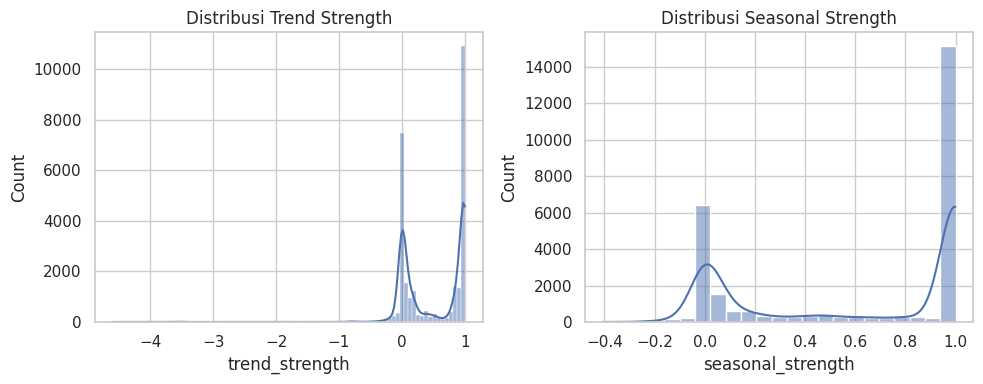

In [15]:
# Visualisasi trend & seasonal
display(stl_stats.describe())
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(stl_stats['trend_strength'], kde=True, ax=ax[0])
ax[0].set_title('Distribusi Trend Strength')
sns.histplot(stl_stats['seasonal_strength'], kde=True, ax=ax[1])
ax[1].set_title('Distribusi Seasonal Strength')
plt.tight_layout()
plt.show()

**1. Trend Strength**
- Mayoritas series (Q2 = 0.724, Q3 = 0.986) memiliki trend_strength tinggi (kemungkinan karena efek imputasi 0 pada tanggal yg gaada transaksinya)
- Sekitar 25 % terendah (Q1 ≈ 0.002) mendekati nol → hampir tidak ada tren, plot mereka relatif datar atau sangat intermiten.  
- Nilai –∞ muncul bila komponen tren hampir nol sementara `residu` ≫ 0 yang artinya series penuh dengan noise

**2. Seasonal Strength**
- Median ≈ 0.993 dan Q3 = 1 menunjukkan lebih dari setengah series memiliki seasonal yang sangat kuat (variasi berulang setiap 12 bulan).  
- Q1 ≈ 0.040 menandakan ~25 % series tidak memiliki seasonal  
- Min ~ –0.405 (beberapa series menghasilkan nilai negatif) menandakan bahwa residual noise lebih besar daripada komponen seasonal

# Stationary Test

In [16]:
# fungsi adf dan kpss
def adf_test(series, maxlag=None):
    """Return p-value dari ADF."""
    result = adfuller(series.dropna(), maxlag=maxlag, autolag='AIC')
    return result[1]   # p-value

def kpss_test(series, regression='c', nlags='auto'):
    """Return p-value dari KPSS."""
    result = kpss(series.dropna(), regression=regression, nlags=nlags)
    return result[1]   # p-value


In [ ]:
# Batch test seluruh SKU
records = []
for sid, grp in tqdm(df.groupby("series_id"), 
                     total=df["series_id"].nunique()):
    # ensure datetime & sort
    tmp = grp.copy()
    tmp["date"] = pd.to_datetime(tmp["date"], errors="coerce")
    tmp = tmp.set_index("date").sort_index()
    
    # resample to monthly (sum all rows in a month)
    ts = tmp["total_qty"].resample("MS").sum()
    
    # fill small gaps by interpolation (or choose fillna(0))
    ts = ts.interpolate(method="linear")
    
    # compute p‑values, handle short series
    if len(ts.dropna()) < 3:
        p_adf, p_kpss = np.nan, np.nan
    else:
        try:
            p_adf  = adf_test(ts)
            p_kpss = kpss_test(ts)
        except Exception:
            p_adf, p_kpss = np.nan, np.nan
    
    records.append({
        "series_id":    sid,
        "adf_pvalue":   p_adf,
        "kpss_pvalue":  p_kpss
    })

stationary_df = pd.DataFrame(records)


# Flag hasil: stasioner bila ADF < 0.05 & KPSS >= 0.05
stationary_df['is_stationary'] = (
    (stationary_df['adf_pvalue']  < 0.05) &
    (stationary_df['kpss_pvalue'] >= 0.05)
)

In [28]:
# Summary
vc = stationary_df['is_stationary'].value_counts()
vc_pct = stationary_df['is_stationary'].value_counts(normalize=True) * 100

summary = pd.DataFrame({
    'count': vc,
    'percent': vc_pct.round(2)
})

print(summary)
display(stationary_df.head())


               count  percent
is_stationary                
True           19245     68.0
False           9056     32.0


,series_id,adf_pvalue,kpss_pvalue,is_stationary
0,10002R_United Kingdom,0.000000e+00,0.081381,True
1,10002_Australia,1.500515e-05,0.100000,True
2,10002_Denmark,9.504682e-19,0.087557,True
3,10002_EIRE,2.147254e-06,0.048086,False
4,10002_France,6.028071e-03,0.098400,True


- 68% series bersifat stationary (dapat menggunakan model2 yang memerlukan asumsi stationary seperti ARIMA)

# Time Series Clustering

Series clustering digunakan untuk mengelompokkan series yang memiliki kemiripan. Hal ini berguna saat modeling sebagai contoh jika training local model maka tidak perlu train model per series tapi bisa disederhanakan menjadi training per cluster

In [29]:
# Merge summary_df, stl_stats, stationary_df
feature_df = summary_df.merge(stl_stats, how = "left", on = "series_id").merge(stationary_df, how = "left", on = "series_id")

In [30]:
# Filter kolom yang dibutuhkan untuk clustering
clustering_features = [ 'total_qty_count', 'total_qty_mean', 'total_qty_median',
       'total_qty_std_dev', 'total_qty_min', 'total_qty_max', 'total_qty_cv', 'trend_strength', 'seasonal_strength', 'adf_pvalue',
       'kpss_pvalue']
# Feature processing
X = feature_df[clustering_features]
X = X.replace([np.inf, -np.inf], np.nan)
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X)
# Normalisasi
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

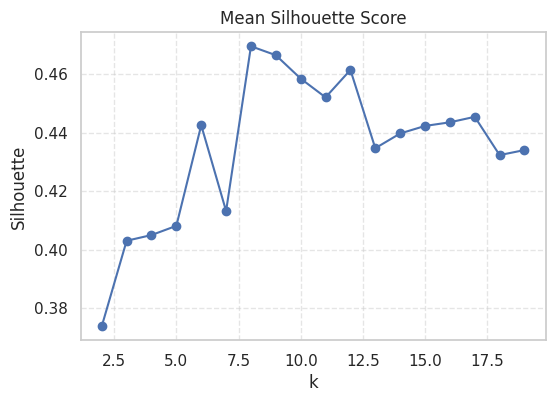

Best K based on Silhouette: 8


In [21]:
# Tetapkan jumlah cluster
K_range = range(2, 20)
inertia  = []
silh     = []

for k in K_range:
    km  = KMeans(n_clusters=k, n_init='auto', random_state=42)
    lbl = km.fit_predict(X_std)
    silh.append(silhouette_score(X_std, lbl))


# Plot Silhouette
plt.figure(figsize=(6,4))
plt.plot(K_range, silh, marker='o')
plt.title("Mean Silhouette Score")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True, ls='--', alpha=.5)
plt.show()

best_k = int(np.argmax(silh)) + 2   # +2 karena range mulai di 2
print(f"Best K based on Silhouette: {best_k}")

In [22]:
# clustering
k = best_k     
kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
labels = kmeans.fit_predict(X_std)

feature_df['cluster'] = labels
centroids = scaler.inverse_transform(kmeans.cluster_centers_)  # balik skala

In [23]:
# Stat per cluster
cluster_stats = (
    feature_df.groupby('cluster')[clustering_features]
              .agg(['count', 'mean'])
              .round(2)
)
display(cluster_stats)

total_qty_count        total_qty_mean          total_qty_median  \
                  count   mean          count     mean            count   
cluster                                                                   
0                 10524  18.53          10524     4.81            10524   
1                  9198   6.66           9198    12.68             9198   
2                     1    1.0              1  80995.0                1   
3                  1095  20.13           1095     26.8             1095   
4                  1333  14.41           1333    94.66             1333   
5                     1   12.0              1  6419.67                1   
6                  2210  18.81           2210    38.03             2210   
7                  3939  24.21           3939    58.73             3939   

                 total_qty_std_dev           total_qty_min           ...  \
            mean             count      mean         count     mean  ...   
cluster                                                              ...   
0           1.06             10524     12.78         10524      0.1  ...   
1           8.08              9017     14.98          9198     2.54  ...   
2        80995.0                 0      <NA>             1  80995.0  ...   
3          15.18              1095     32.74          1095      2.1  ...   
4          75.67              1333     81.65          1333    13.97  ...   
5          263.5                 1  21351.09             1      0.0  ...   
6          27.06              2210     34.95          2210     4.94  ...   
7          36.16              3939     73.48          3939     5.58  ...   

        total_qty_cv       trend_strength       seasonal_strength        \
               count  mean          count  mean             count  mean   
cluster                                                                   
0              10524  3.55          10524  0.02             10524  0.12   
1               9017  2.11           9016  -inf              9017  0.99   
2                  0  <NA>              0   NaN                 0   NaN   
3               1095  1.92           1095  0.01              1095  0.31   
4               1333  1.38           1333  0.91              1333  0.98   
5                  1  3.33              1  0.98                 1  1.00   
6               2210  1.82           2210  0.65              2210  0.67   
7               3939  2.53           3939  0.85              3939  0.98   

        adf_pvalue       kpss_pvalue        
             count  mean       count  mean  
cluster                                     
0            10523  0.01       10523  0.10  
1             6467  0.02        6467  0.10  
2                0   NaN           0   NaN  
3             1095  0.74        1095  0.09  
4             1333  0.76        1333  0.09  
5                1  0.00           1  0.10  
6             2210  0.11        2210  0.04  
7             3939  0.03        3939  0.10  

[8 rows x 22 columns]

**Jumlah cluster terbentuk: 8**  

* **Ukuran cluster timpang**  
  - Terbesar: **Cluster 0 (10524 series)**  
  - Terkecil: **Cluster 2 (1 series)**, **Cluster 5 (1 series)** ⇒ kandidat outlier


# Add basic Feature

In [24]:
# Sort values by series_id & date
df = df.sort_values(['series_id', 'date']).reset_index(drop=True)

# Time based feature
df['year']    = df['date'].dt.year
df['month']   = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['time_idx'] = df.groupby('series_id').cumcount()

# Lag Features
for lag in [1, 2, 3, 6, 12]:
    df[f'lag_qty_{lag}'] = (
        df.groupby('series_id')['total_qty']
          .shift(lag)
    )
# Rolling statistics
windows = [3, 6, 12]
grp = df.groupby("series_id")["total_qty"]
for w in windows:
    roll = grp.rolling(window=w, min_periods=1)
    df[f"qty_roll_mean_{w}"]   = roll.mean().reset_index(0, drop=True)
    df[f"qty_roll_std_{w}"]    = roll.std().reset_index(0, drop=True)
    df[f"qty_roll_min_{w}"]    = roll.min().reset_index(0, drop=True)
    df[f"qty_roll_max_{w}"]    = roll.max().reset_index(0, drop=True)
    df[f"qty_roll_median_{w}"] = roll.median().reset_index(0, drop=True)
    df[f"qty_roll_q1_{w}"]     = roll.quantile(0.25).reset_index(0, drop=True)
    df[f"qty_roll_q3_{w}"]     = roll.quantile(0.75).reset_index(0, drop=True)

# Price dynamic
df['price_change_1']    = df.groupby('series_id')['avg_unit_price'].pct_change(1)
df['roll_price_mean_3'] = (
    df.groupby('series_id')['avg_unit_price']
      .rolling(3).mean()
      .reset_index(0, drop=True)
)


# Export Feature

In [25]:
# Export to parquet
feature_df.to_parquet("data/preprocessed/stats_series.parquet", index = False)
df.to_parquet("data/preprocessed/df_feature.parquet", index = False)